In [1]:
import pandas as pd

file_location = ""
file_name = "PlatePlan0_setup.csv"

df = pd.read_csv(file_location+file_name,
                 comment = "#",
                 skipinitialspace=True)

row_name_list = df["Row"].dropna()
S_conc_list = df["S_Conc"].dropna() * 1E-3  ### convert millimolar to molar

lane_name_list = df["Column"]
E_conc_list = df["E_Conc"] * 1E-9  ### convert nanomolar to molar
kcat_list = df["kcat"] * 60        ### convert /s to /min
Vmax_list = kcat_list * E_conc_list ## Vmax from kcat and [E]
KM_list = df["KM"] * 1E-3          ### conver mM to M

### parameters to get extinction coeff for NPA at give pH value
pH = 7.0
e_NPAA = 18300  ### extinction coeff for NPA anion
pKa_NPA = 7.15 ### pKa for p-nitrophenol

### Calculated Values from the above lists
Ka = 10 ** -pKa_NPA   ### extinction coeff for NPA at given pH
H = 10 ** -pH
e_NPA = e_NPAA * (Ka / (H + Ka))

display(df)


,Column,Enzyme,E_Conc,Row,S_Conc,kcat,KM
0,1,None,0.00,A,0.005,100,0.05
1,2,None,0.00,B,0.010,100,0.05
2,3,None,0.00,C,0.020,100,0.05
3,4,wt1,1.00,D,0.030,100,0.05
4,5,wt1,1.00,E,0.060,100,0.05
5,6,wt1,1.00,F,0.100,100,0.05
6,7,wt1,0.50,G,0.200,100,0.05
7,8,wt1,0.50,H,0.500,100,0.05
8,9,wt1,0.50,NaN,NaN,100,0.05
9,10,wt1,0.25,NaN,NaN,100,0.05


In [2]:
### This creates the data set separate x,y data files names as lane,row

data_name = "data1/data"
data_file_extention = ".csv"

#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT

import numpy as np
import pandas as pd

eq, f = BT.get_integrated_MM_function()

time_start = 0.5
time_end = 60           ### The end time
n_points = 360          ### number of points - increase if needed

voltage_error = 0.001   ### parameters to define output range and error
random_error = 0.001
max_value = 4

dt = time_end / n_points          ### time step, delta t
t_line = np.arange(time_start,    ### time vector (list of time points)
                   time_end + dt, 
                   dt) 

### Note: Lane names, enzyme conc list, KM list and Vmax list must all be
### same length or this will fail. Row names and row concentration lists 
### must also have equal lengths.


parameters = zip(lane_name_list, Vmax_list, KM_list)
for p in parameters:
    lane_name, Vmax_value, KM_value = p   ### unpack kcat, KM and [E]
    #print(lane_name)

    row_info = zip(row_name_list, S_conc_list)
    for row in row_info:
        row_name, S0_value = row      ### unpack row name and substrate conc
        plate_df = pd.DataFrame([])   ### start with empty dataframe
        #print(row_name)

        ### Calculate product from enzyme reaction 
        product_E = S0_value - f(t_line, S0_value, KM_value, Vmax_value)   
        product_E = np.real(product_E)  ### complex numbers fixed

        ### Calculate product from uncatalyzed reaction 
        product_NPA = S0_value - S0_value * np.exp(-1E-3 * t_line)
        product = product_E + product_NPA
        absorbance = product * e_NPA   ### result in absorbance units

        ### Add voltage error 
        fraction_transmittance  = 1 / (10 ** absorbance)                      
        fraction_transmittance = np.random.normal(fraction_transmittance, 
                                                  voltage_error, 
                                                  len(fraction_transmittance))
        absorbance = -np.log10(fraction_transmittance)

        ### Add random error
        absorbance = np.random.normal(absorbance,     
                                      random_error, 
                                      len(absorbance))   

        absorbance[absorbance > max_value] = max_value   ### cap values 
        absorbance = np.nan_to_num(absorbance,  ### replace NaN with max value
                          copy = True, 
                          nan = max_value)   

        ### insert the two data arrays into the dataframe
        plate_df["time"] = t_line
        plate_df["abs"] = absorbance

        ### Write data out to file using lane_name and row_name
        out_file_name = str(data_name) + "_" + str(lane_name) + "_" \
            + str(row_name) + data_file_extention
        plate_df.to_csv(out_file_name, float_format='%10.4g')



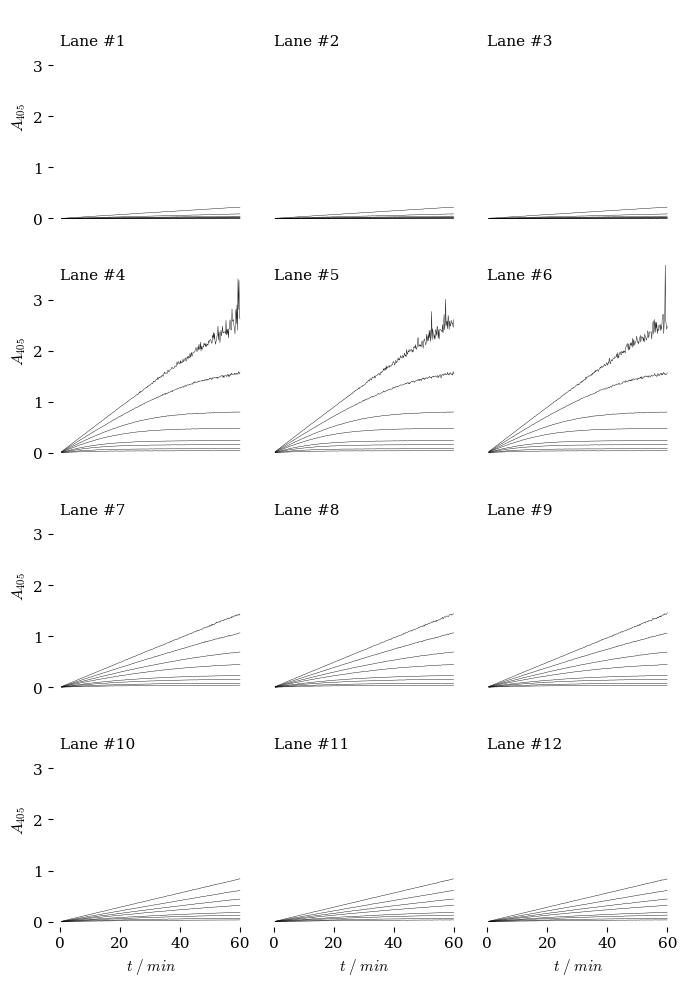

Plot saved as plot_contact_sheet.pdf


()

In [2]:
### Contact sheet. Ticks deleted on plots inside the set.
#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT


BT.contact_sheet("data1/data", fancy = True)

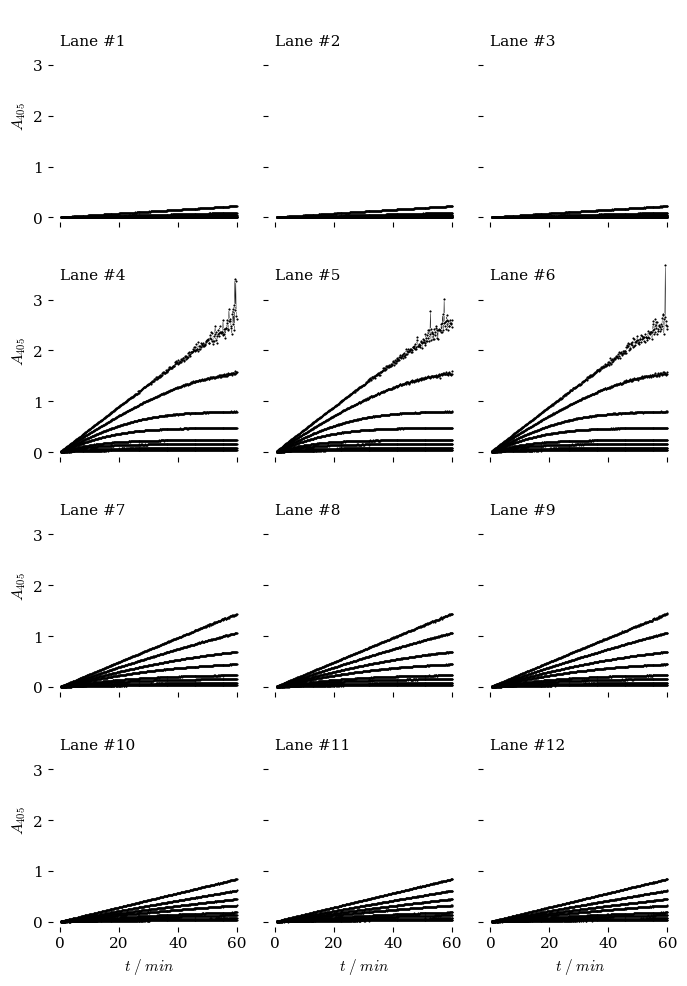

In [10]:
### Contact sheet using shared axes. Ticks will be on each plot.

from matplotlib import pyplot as plt

plt.ioff()      ### switch off interactive display of plots. plt.show() needed to display a plot now
plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=4, 
                       ncols=3, 
                       figsize=(7,10), 
                       sharex=True, 
                       sharey=True
                       )  

data_name = "data1/data"
data_file_extention = ".csv"

n = 0

for lane_name in lane_name_list:
    
    plot_row = n // 3
    plot_col = n % 3

    ax[plot_row][plot_col].set(
                xlabel= None, 
                ylabel=None,
            #    title = "Lane # "+str(lane_name),
            #    xlim=[None, None],                  
                ylim=[-.1, 4.1]      
               )
    ax[plot_row][0].set(ylabel= r"$A_{405}$")

    ax[3][plot_col].set(xlabel= r"$t\;/\;min$")

    ax[plot_row][plot_col].set_yticks([0,1,2,3])
    ax[plot_row][plot_col].text(0, 3.4, "Lane #"+str(lane_name)) 

    for row_name in row_name_list:
        in_file_name = data_name + "_" + str(lane_name) + "_" \
             + row_name + data_file_extention

        df = pd.read_csv(in_file_name)

        x = df["time"] 
        y = df["abs"] 
        ax[plot_row][plot_col].plot(x, y, 
                                    linestyle = '-', 
                                    linewidth='0.3', 
                                    color = 'black', 
                                    zorder = 0)
        ax[plot_row][plot_col].scatter(x, y, 
                                       marker='o', 
                                       color='black', 
                                       edgecolors = None,
                                       linewidths = 0.5, 
                                       s=1, 
                                       zorder = 2)
        ax[plot_row][plot_col].scatter(x, y, 
                                       marker='o', 
                                       color='white', 
                                       edgecolors = None,
                                       linewidths = 0.5, 
                                       s=4, 
                                       zorder = 1)

    n += 1

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("plot.pdf")     ### export the plot as this
plt.show()                 ### display the plot in this notebook


In [15]:
import random
import string

for x in range(12):
   random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=3))
   print(random_string)

dir(string)
help(string)

44Y
6KD
Z23
T88
PI9
41K
Q8W
MJP
ZUW
VCS
750
GAR
Help on module string:

NAME
    string - A collection of string constants.

MODULE REFERENCE
    https://docs.python.org/3.11/library/string.html
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

DESCRIPTION
    Public module variables:
    
    whitespace -- a string containing all ASCII whitespace
    ascii_lowercase -- a string containing all ASCII lowercase letters
    ascii_uppercase -- a string containing all ASCII uppercase letters
    ascii_letters -- a string containing all ASCII letters
    digits -- a string containing all ASCII decimal digits
    hexdigits -- a string containing all ASCII hexadecimal digits
    octdigits -- a string containing all ASCII o

In [10]:
8.314*298*np.log(390/3) + (+2)*96500*(-0.02)

8199.667063484138

In [23]:
-26000 + 8.314*298*np.log((2.9*1) / (0.0015*0.051))

120.8695388426313